In [103]:
import os
import re
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import defaultdict, Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import string
from spellchecker import SpellChecker
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(f'Train data dimension: {train_df.shape}')
print(f'Test data dimension: {test_df.shape}')

Train data dimension: (7613, 5)
Test data dimension: (3263, 4)


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot: xlabel='target', ylabel='count'>

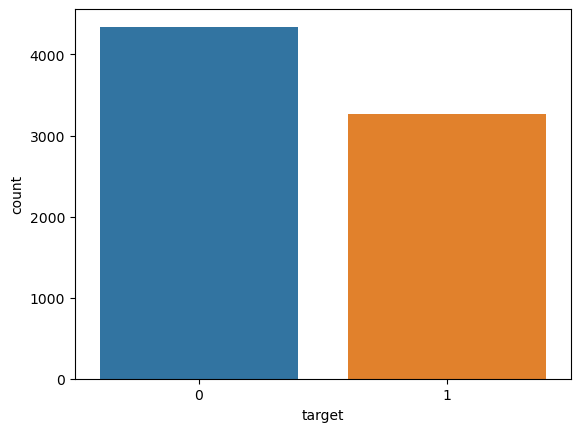

In [4]:
sns.countplot(x = train_df.target)

In [5]:
pos_tweets = train_df[train_df['target'] == 1]
neg_tweets = train_df[train_df['target'] == 0]
pos_tmp = [wList for wList in pos_tweets.text.str.split()]
neg_tmp = [wList for wList in neg_tweets.text.str.split()]

Text(0.5, 1.0, 'Distribution of number of Words in \nDisaster-negative tweets')

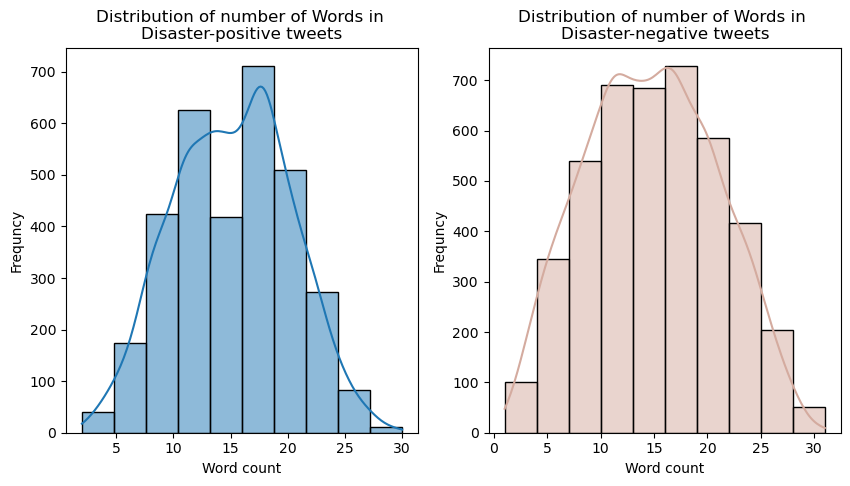

In [6]:
pos_tweets_words = pos_tweets.text.str.split().map(lambda x: len(x))
neg_tweets_words = neg_tweets.text.str.split().map(lambda x: len(x))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
sns.histplot(pos_tweets_words, bins = 10, kde = True, ax = ax1)
ax1.set_xlabel('Word count')
ax1.set_ylabel('Frequncy')
ax1.set_title('Distribution of number of Words in \nDisaster-positive tweets')

sns.histplot(neg_tweets_words, bins = 10, kde = True, color = '#d4ab9f', ax = ax2)
ax2.set_xlabel('Word count')
ax2.set_ylabel('Frequncy')
ax2.set_title('Distribution of number of Words in \nDisaster-negative tweets')

(0.0, 20.0)

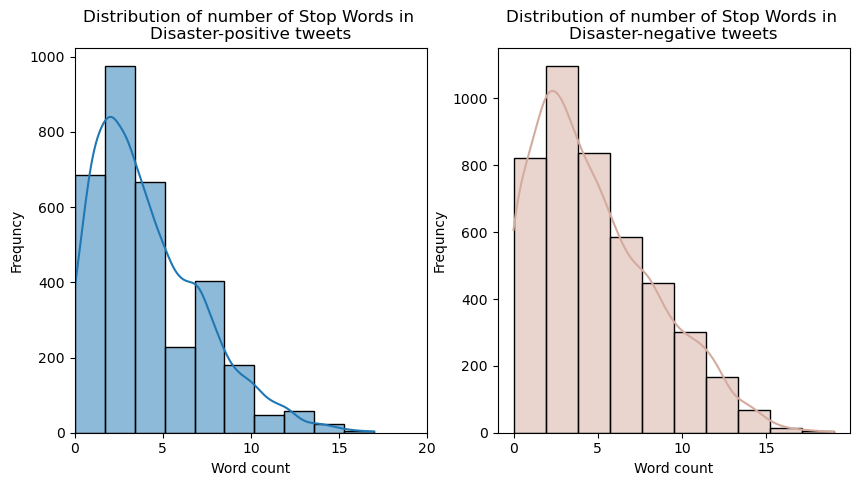

In [7]:
stop=set(stopwords.words('english'))
pos_tweets_stop = pos_tweets.text.apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))
neg_tweets_stop = neg_tweets.text.apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
sns.histplot(pos_tweets_stop, bins = 10, kde = True, ax = ax1)
ax1.set_xlabel('Word count')
ax1.set_ylabel('Frequncy')
ax1.set_title('Distribution of number of Stop Words in \nDisaster-positive tweets')

sns.histplot(neg_tweets_stop, bins = 10, kde = True, color = '#d4ab9f', ax = ax2)
ax2.set_xlabel('Word count')
ax2.set_ylabel('Frequncy')
ax2.set_title('Distribution of number of Stop Words in \nDisaster-negative tweets')
ticks = ax2.get_xticks()
ax1.set_xticks(ticks)
ax1.set_xlim([0, 20])


In [8]:
def countCommonWord(List):
    d = defaultdict(int)
    for l in List:
        for word in l:
            if word not in stop:
                d[word] += 1
    return d


In [9]:
pos_txt = ''.join([''.join(i) for i in pos_tmp])
neg_txt = ''.join([''.join(i) for i in neg_tmp])

In [33]:
def plotWordCloud(txt):
    wordcloud = WordCloud(max_font_size=80, max_words=160, background_color="white").generate(txt)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

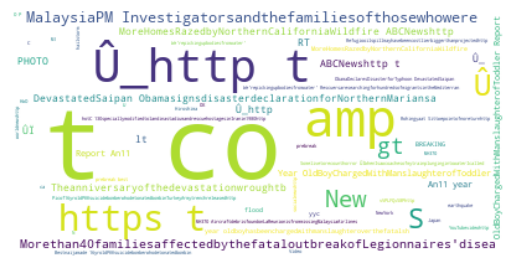

In [34]:
plotWordCloud(pos_txt)

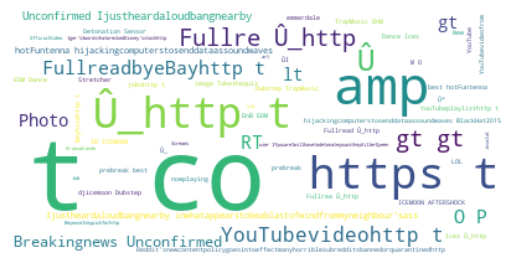

In [35]:
plotWordCloud(neg_txt)

In [13]:
def countSpecial(List, specials):
    d = defaultdict(int)
    for word in List:
        if word in specials:
            d[word] += 1
    return d

In [14]:
sp_chr = string.punctuation
p_sp = countSpecial(list(itertools.chain(*pos_tmp)), sp_chr)
n_sp = countSpecial(list(itertools.chain(*neg_tmp)), sp_chr)

In [15]:
def countPlot(pairs, xl, yl, ori = 'v', c ='#ffa500'):
    x, y = zip(*pairs)
    df = pd.DataFrame([])
    if ori == 'v':
        df[xl] = x
        df[yl] = y
        sns.barplot(y = yl, x = xl, data = df, color = c)
    else:
        df[yl] = x
        df[xl] = y
        sns.barplot(y = yl, x = xl, data = df, color = c)


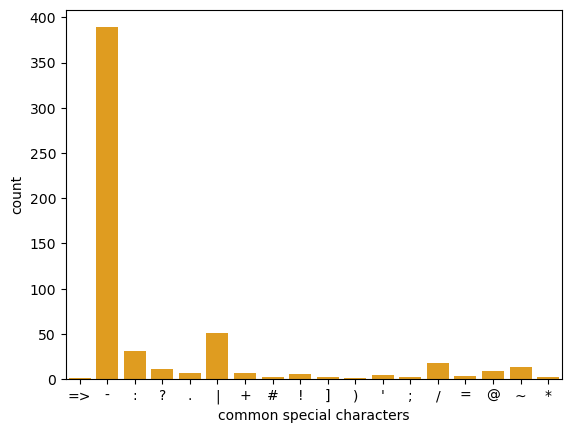

In [16]:
countPlot(p_sp.items(), 'common special characters', 'count')

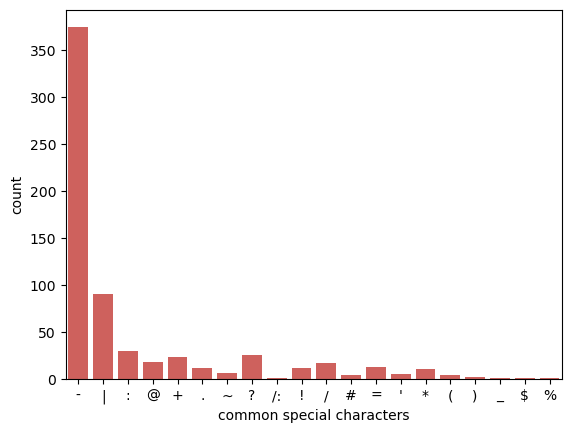

In [17]:
countPlot(n_sp.items(), 'common special characters', 'count', c ='#e1504a')

In [18]:
def countStop(List):
    d = defaultdict(int)
    for l in List:
        for word in l:
            if word in stop:
                d[word] += 1
    return d


In [19]:
p20stop = sorted(countStop(pos_tmp).items(), key = lambda x:x[1], reverse = True)[:20]
n20stop = sorted(countStop(neg_tmp).items(), key = lambda x:x[1], reverse = True)[:20]

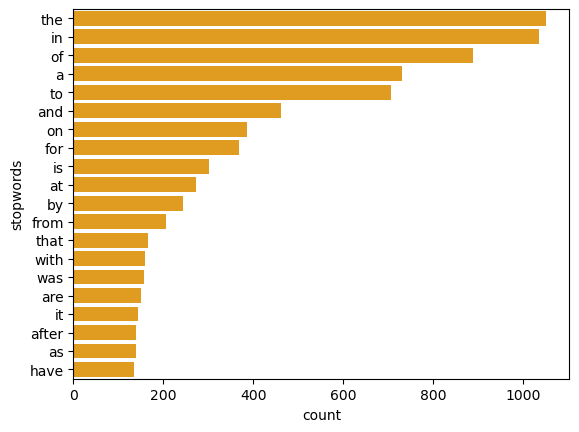

In [20]:
countPlot(p20stop, 'count', 'stopwords', ori = 'h')

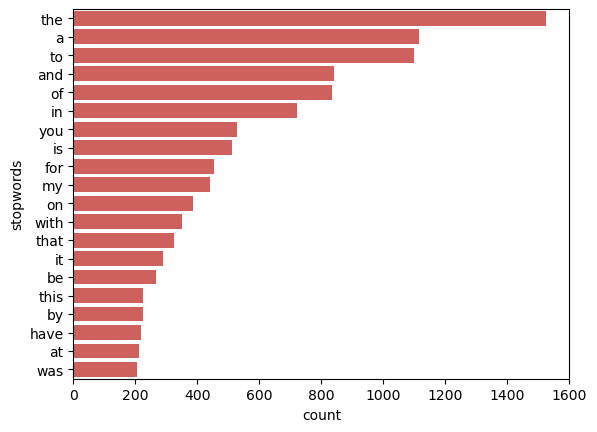

In [22]:
countPlot(n20stop, 'count', 'stopwords', c = '#e1504a', ori = 'h')

In [23]:
def remove_html(txt):
    tag = re.compile(r'<.*?>')
    out1 = tag.sub(r'', txt)
    url = re.compile(r'https?://\S+|www\.\S+')
    out2 = url.sub(r'', out1)
    return out2

In [24]:
test = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
"New competition launched :https://www.kaggle.com/c/nlp-getting-started"
</div>"""

test2 = "New competition launched :https://www.kaggle.com/c/nlp-getting-started"

remove_html(test)

'\nReal or Fake\nKaggle \ngetting started\n"New competition launched :\n'

In [25]:
def remove_specials(txt):
    tmp = str.maketrans('', '', string.punctuation)
    return txt.translate(tmp)

In [26]:
test = 'I #!-@/*()am John'

remove_specials(test)

'I am John'

In [27]:
def remove_emoji(txt):
    pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return pattern.sub(r'', txt)

In [28]:
test = '😊 😊 remove emojis 😔😔'
remove_emoji(test)

'  remove emojis '

In [29]:
def remove_number(txt):
    pattern = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return pattern.sub(r'', txt)

In [30]:
test = 'Remove 123 <- these numbers'
remove_number(test)

'Remove  <- these numbers'

In [31]:
spell = SpellChecker()

In [51]:
def correct_spellings(txt):
    out = []
    misspelled = spell.unknown(txt.split())
    for word in txt.split():
        if word in misspelled:
            out.append(spell.correction(word))
        else:
            out.append(word)
    
    return ' '.join(out)


'!'

In [55]:
text = "correct me please"
correct_spellings(text)

'correct me please'

In [85]:
def clean_data(df):
    df['cleaned'] = df['text'].apply(lambda x: remove_html(x))
    df['cleaned'] = df['cleaned'].apply(lambda x: remove_specials(x))
    df['cleaned'] = df['cleaned'].apply(lambda x : remove_emoji(x))
    df['cleaned'] = df['cleaned'].apply(lambda x: remove_number(x))
    return df


In [88]:
cleaned_df = clean_data(pos_tweets)

/var/folders/2w/3s_c9j7s53ndtgsq0z2lpmdr0000gn/T/ipykernel_2095/3027247702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned'] = df['text'].apply(lambda x: remove_html(x))
/var/folders/2w/3s_c9j7s53ndtgsq0z2lpmdr0000gn/T/ipykernel_2095/3027247702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned'] = df['cleaned'].apply(lambda x: remove_specials(x))
/var/folders/2w/3s_c9j7s53ndtgsq0z2lpmdr0000gn/T/ipykernel_2095/3027247702.py:4: SettingWithCopyWarning: 
A value is trying to be set

In [89]:
cleaned_df

,id,keyword,location,text,target,cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The out of control wild...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M UTCkm S of Volcano Hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an ebike collided w...


In [98]:
def gen_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [100]:
corpus = gen_corpus(cleaned_df)

100%|█████████████████████████████████████████| 3271/3271 [00:00<00:00, 5811.16it/s]


In [104]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
word_index = tokenizer_obj.word_index

tweet_pad = pad_sequences(sequences, maxlen=100, truncating='post', padding='post')
word_index = tokenizer_obj.word_index

In [109]:
cleaned_df["encoded"] = tokenizer_obj.texts_to_sequences(cleaned_df["cleaned"])
cleaned_df["len_words"] = cleaned_df["encoded"].apply(lambda x: len(x))
cleaned_df.head()

/var/folders/2w/3s_c9j7s53ndtgsq0z2lpmdr0000gn/T/ipykernel_2095/2897656954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["encoded"] = tokenizer_obj.texts_to_sequences(cleaned_df["cleaned"])
/var/folders/2w/3s_c9j7s53ndtgsq0z2lpmdr0000gn/T/ipykernel_2095/2897656954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["len_words"] = cleaned_df["encoded"].apply(lambda x: len(x))


,id,keyword,location,text,target,cleaned,encoded,len_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[403, 3312, 425, 3, 888, 140, 33, 74, 59, 1005...",13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[56, 4, 66, 326, 3314, 3315, 645]",7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[263, 799, 3316, 67, 1156, 11, 462, 425, 523, ...",22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,"[14, 2233, 646, 87, 727, 11, 12]",7
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[327, 125, 1392, 33, 345, 103, 3318, 1157, 178...",16


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  403 3312  888   74   59 1005
 3313   65]


['our deeds reason earthquake may allah forgive us']

In [81]:
df['cleaned'] = df['text'].apply(lambda x: remove_html(x))
df['cleaned'] = df['cleaned'].apply(lambda x: remove_specials(x))
df['cleaned'] = df['cleaned'].apply(lambda x : remove_emoji(x))
df['cleaned'] = df['cleaned'].apply(lambda x: remove_number(x))


In [83]:
df['cleaned'] = df['cleaned'].apply(lambda x: correct_spellings(x))

TypeError: sequence item 2: expected str instance, NoneType found

In [84]:
df

,id,keyword,location,text,target,cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The out of control wild...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M UTCkm S of Volcano Hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an ebike collided w...
